In [1]:
from ocsmesh import Raster, Geom, Hfun, Mesh, JigsawDriver, utils
import geopandas as gpd

In [2]:
from shapely.ops import unary_union
import pyproj
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from copy import deepcopy
from matplotlib.tri import Triangulation

In [4]:
cb = gpd.read_file('CB_coast.shp')

In [5]:
crs_4326 = pyproj.CRS.from_epsg(4326)
crs_3112 = pyproj.CRS.from_epsg(3112) # GDA94 / Geoscience Australia Lambert projected coordinates

In [6]:
files ='roi.shp'
roi = gpd.read_file(files)
cb = cb.clip(roi.geometry[0])

In [7]:
roi

,FID,geometry
0,0,"POLYGON ((115.73951 -32.07771, 115.73772 -32.0..."


In [8]:
cb

,FID,geometry
0,1,"MULTIPOLYGON (((115.75129 -32.07722, 115.75129..."
10,11,"POLYGON ((115.90811 -32.03199, 115.90802 -32.0..."
11,12,"POLYGON ((115.91173 -32.03171, 115.91177 -32.0..."
12,13,"POLYGON ((115.90422 -32.03010, 115.90405 -32.0..."
15,16,"POLYGON ((115.88771 -31.96250, 115.88774 -31.9..."
16,17,"POLYGON ((115.91178 -31.93663, 115.91175 -31.9..."
17,18,"POLYGON ((115.91080 -31.93714, 115.91080 -31.9..."
18,19,"POLYGON ((115.94029 -31.92246, 115.94027 -31.9..."


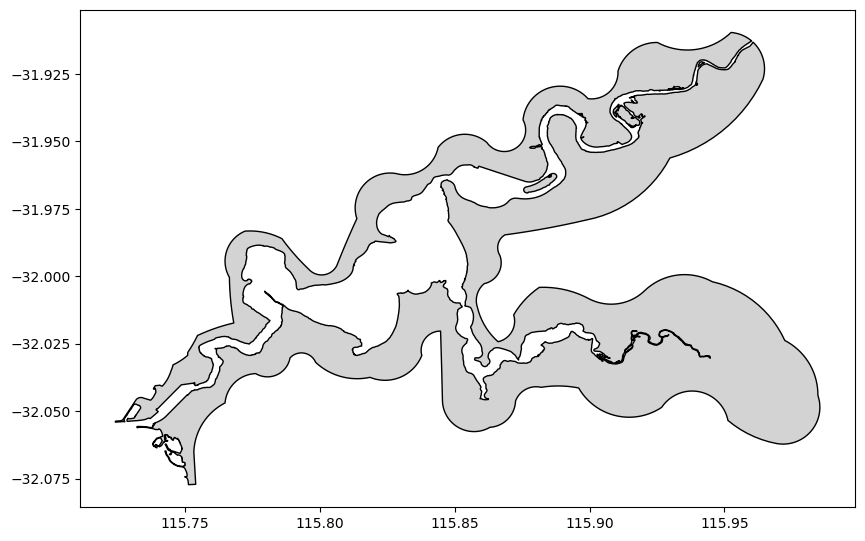

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cb.plot(ax=ax, color='lightgray', edgecolor='black');

In [10]:
cb.crs = "EPSG:4326"

In [11]:
cbm = cb.to_crs(crs_3112)

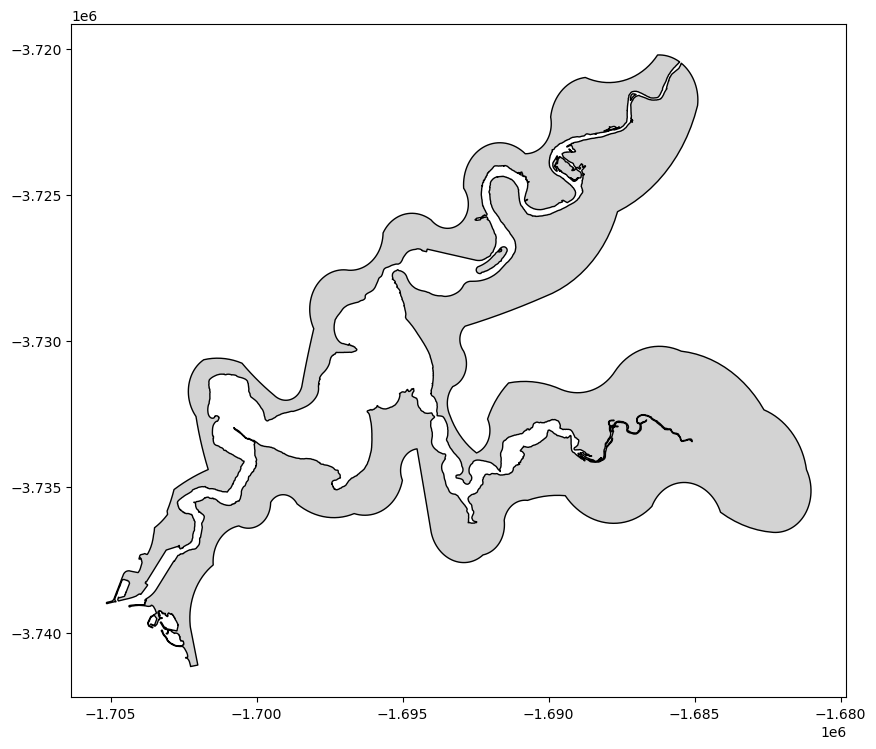

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cbm.plot(ax=ax, color='lightgray', edgecolor='black');

In [13]:
min_island_area = 1e4 # filter out small islands
mask = cbm.area > min_island_area
cbm2 = cbm
cbm2 = cbm2.loc[mask]

In [14]:
cbm2

,FID,geometry
0,1,"MULTIPOLYGON (((-1702263.913 -3741151.690, -17..."
15,16,"POLYGON ((-1691438.305 -3726829.319, -1691433...."
16,17,"POLYGON ((-1689614.102 -3723691.920, -1689615...."
17,18,"POLYGON ((-1689696.408 -3723760.290, -1689695...."
18,19,"POLYGON ((-1687192.311 -3721767.557, -1687194...."


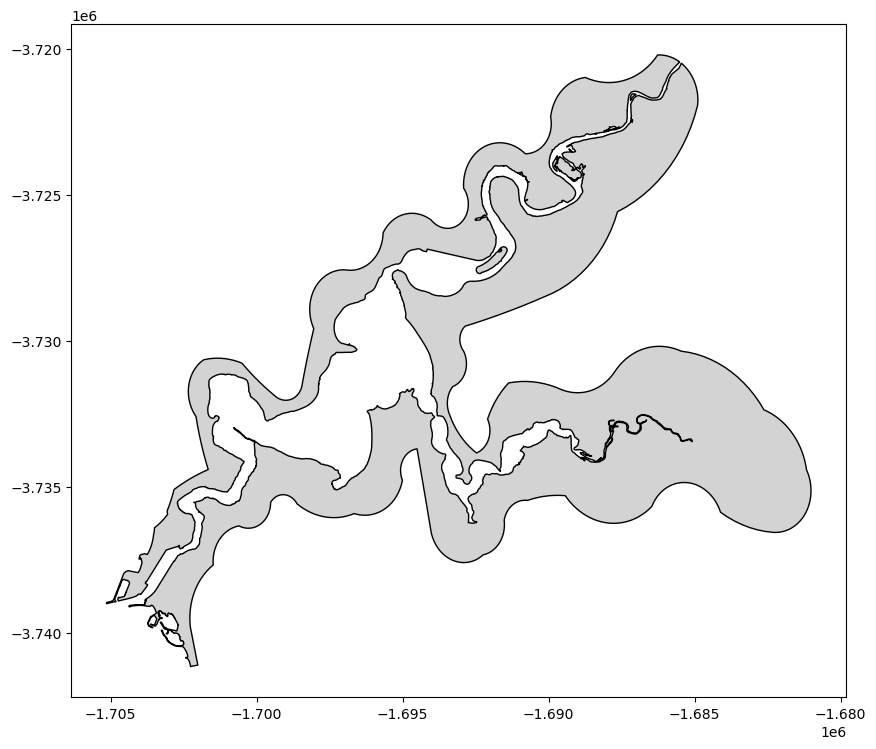

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cbm2.plot(ax=ax, color='lightgray', edgecolor='black');

In [16]:
roi.crs = "EPSG:4326"

In [17]:
roim = roi.to_crs(crs_3112)

In [18]:
domain = roim['geometry'].subtract(cbm2.unary_union)  # this is projected to meters

/home/smani/miniconda3/envs/meshdev/lib/python3.10/site-packages/pandas/core/ops/__init__.py:197: FutureWarning: '-' operator will be deprecated. Use the 'difference' method instead.
  return op(self, other)


In [19]:
domain

0    POLYGON ((-1703518.719 -3741347.906, -1703690....
dtype: geometry

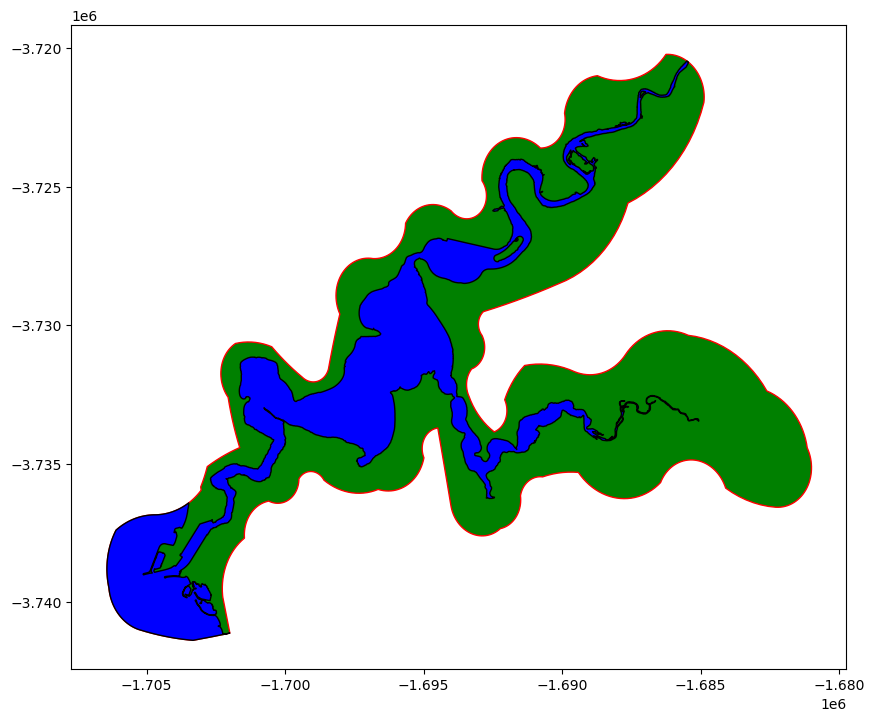

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
roim.plot(ax=ax, color='green', edgecolor='red')
domain.plot(ax=ax, color='blue', edgecolor='black');

In [21]:
#domain.to_file('geometry.shp') 

In [22]:
domainll = domain.to_crs(crs_4326)

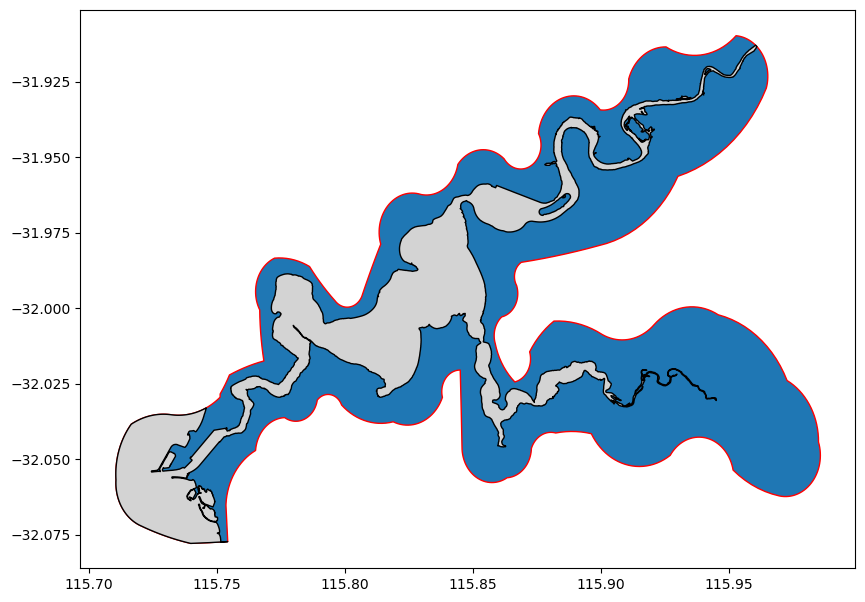

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
roi.plot(ax=ax, color=None, edgecolor='red')
domainll.plot(ax=ax, color='lightgray', edgecolor='black');

<Axes: >

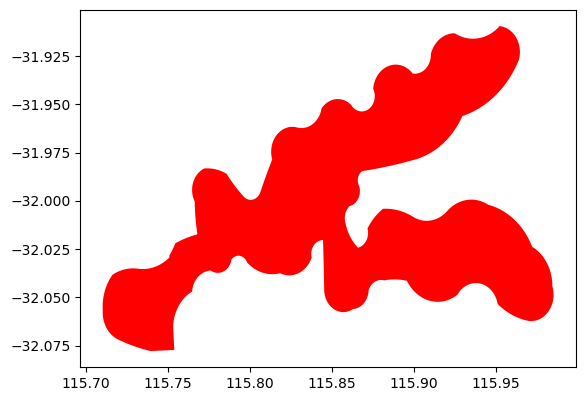

In [33]:
roi.plot(color='red')

In [24]:
# need to have proper raster with variables lon, lat, Band1 and crs
# Using NCO tools does the thing
# ncks -v crs swan_topo.nc -A -o Freo_lidar_0.5s.nc
# ncrename -v z,Band1 Freo_lidar_0.5s.nc
# ncatted -a grid_mapping,Band1,a,c,"crs" Freo_lidar_0.5s.nc

In [25]:
rasters = [Raster('swan_topo.nc'), Raster('Freo_lidar_0.5s.nc')]

In [42]:
geom = Geom(
    deepcopy(rasters),
    zmax=5,
    base_shape=roim.unary_union,
    base_shape_crs=roim.crs,
)
domain_poly = geom.get_multipolygon()

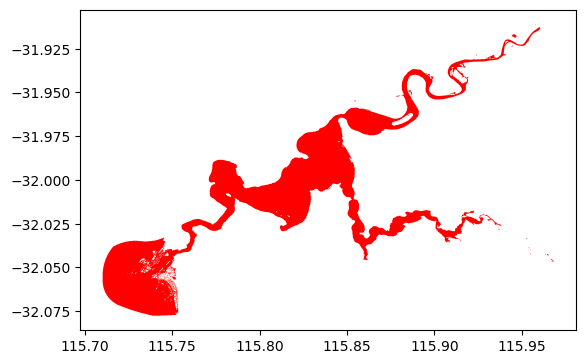

In [43]:
fig, ax = plt.subplots(1, 1)
gpd.GeoSeries(domain_poly).plot(ax=ax, color='r')
ax.set_aspect(1)


/tmp/ipykernel_1167/3311746318.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_main = gpd.GeoDataFrame(geometry=gdf_polys.iloc[gdf_polys.area.argmax()])


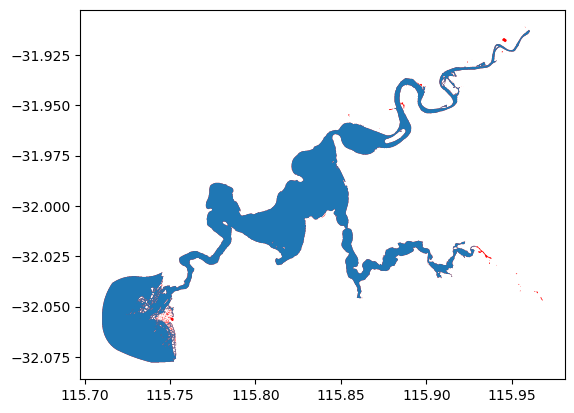

In [66]:
gdf_polys = gpd.GeoDataFrame(geometry=[domain_poly], crs=geom.crs).explode(ignore_index=True)
gdf_main = gpd.GeoDataFrame(geometry=gdf_polys.iloc[gdf_polys.area.argmax()])

fig, ax = plt.subplots(1, 1)
gpd.GeoSeries(domain_poly).plot(ax=ax, color='r')
gdf_main.plot(ax=ax)

geom_main = Geom(gdf_main.unary_union, crs=gdf_main.crs)

In [28]:
hfun = Hfun(
    deepcopy(rasters),
    hmin=50,
    hmax=500,
    base_shape=domain.unary_union,
    base_shape_crs=domain.crs
)

#hfun.add_feature(gpd.GeoSeries(domain_poly, crs=4326).to_crs(roim.crs).boundary, target_size=50)
hfun.add_constant_value(500, lower_bound=2)
hfun.add_constant_value(200, lower_bound=1)

#hfun.add_contour(
#    level=0,
#    target_size=50,
#    expansion_rate=0.004,
#)

hfun.add_contour(
    level=-5,
    target_size=50,
    expansion_rate=0.002,
)
hfun.add_contour(
    level=-10,
    target_size=100,
    expansion_rate=0.001,
)



In [29]:
hfun_msht = hfun.msh_t()

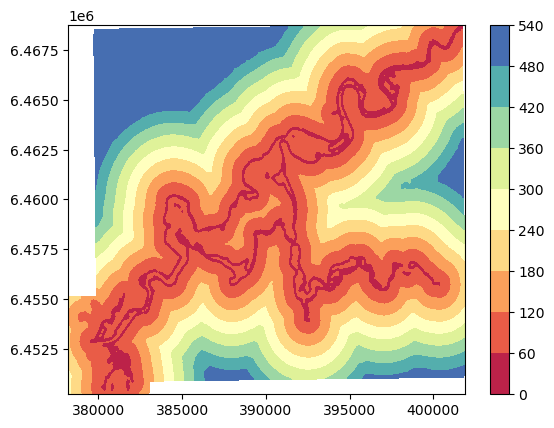

In [30]:
fig, ax = plt.subplots(1, 1)
plt.tricontourf(
    Triangulation(
        hfun_msht.vert2['coord'][:, 0],
        hfun_msht.vert2['coord'][:, 1],
        triangles=hfun_msht.tria3['index']
    ),
    hfun_msht.value.flatten(),cmap='Spectral'
)
#roim.plot(ax=ax, color=None, edgecolor='red')
plt.colorbar();

In [67]:
driver = JigsawDriver(geom_main, hfun, initial_mesh=False)
mesh = driver.run()

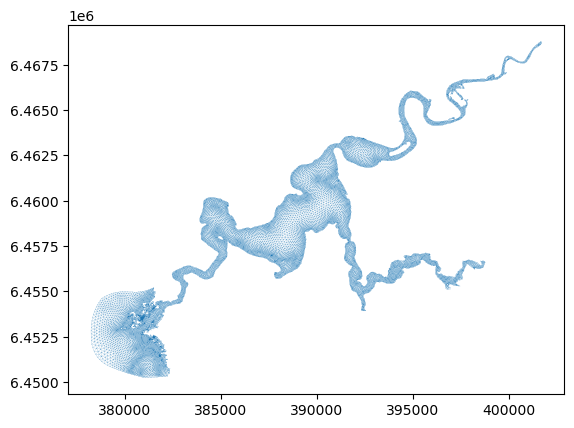

In [68]:
%matplotlib inline
plt.triplot(
    mesh.msh_t.vert2['coord'][:, 0],
    mesh.msh_t.vert2['coord'][:, 1],
    triangles=mesh.msh_t.tria3['index'],
    lw=0.1
);

In [104]:
np.shape(mesh.coord)

(35895, 2)

In [105]:
mesh.interpolate(rasters)

In [107]:
mesh.value

array([[         nan],
       [         nan],
       [         nan],
       ...,
       [250.04317894],
       [239.94447014],
       [248.80885136]])